## Supplementary Figure 3

Comparing spherized normalization, subsampled scores, and median normalization in percent replicating scores

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
get_scores <- function(file_indicator) {
    pr_df <- load_percent_replicating(
        assay = "cellpainting",
        results_dir = results_dir,
        cp_file_indicator = file_indicator
    )
    
    pr_df$dose <- factor(pr_df$dose, levels = dose_order)
    
    threshold_df <- pr_df %>%
        dplyr::filter(type == 'non_replicate') %>%
        dplyr::group_by(assay, dose) %>%
        dplyr::summarise(threshold = quantile(replicate_correlation, 0.95))

    percent_replicating_df <- pr_df %>%
        dplyr::left_join(threshold_df, by = c("assay", "dose")) %>%
        dplyr::filter(type == "replicate") %>%
        dplyr::mutate(pass_threshold = threshold < replicate_correlation) %>%
        dplyr::group_by(dose, assay) %>%
        dplyr::summarize(percent_replicating = 100 * (sum(pass_threshold) / length(pass_threshold))) %>%
        dplyr::ungroup()
    
    return(list("threshold" = threshold_df, "percent_replicating" = percent_replicating_df, "median_cor_distrib" = pr_df))
}

In [3]:
output_figure_base <- file.path("figures", "supplementary", "supfigure3")
extensions <- c(".png", ".pdf")

In [4]:
results_dir <- file.path("../1.Data-exploration/Profiles_level4/results")

In [5]:
cp_labels = c(
    "full non-spherized" = "All replicates (non-spherized)",
    "full spherized" = "All replicates (spherized)",
    "subsampled spherized" = "n=3 subsampled (spherized)"
)
cp_values = c(
    "full non-spherized" = "#1e81b0",
    "full spherized" = "#2d1d16",
    "subsampled spherized" = "#e28743"
)

In [6]:
# Get percent replicating scores
cp_file_indicator <- "_nonspherized"
non_spherized_info <- get_scores(cp_file_indicator)

cp_file_indicator <- "_subsample"
subsample_info <- get_scores(cp_file_indicator)

cp_file_indicator <- ""
standard_info <- get_scores(cp_file_indicator)

# Extract and combine percent replicating results
non_spherized_df <- non_spherized_info[["percent_replicating"]] %>%
    dplyr::mutate(sample_type = "full non-spherized")

subsampled_df <- subsample_info[["percent_replicating"]] %>%
    dplyr::mutate(sample_type = "subsampled spherized")

original_df <- standard_info[["percent_replicating"]] %>%
    dplyr::mutate(sample_type = "full spherized")

pr_df <- dplyr::bind_rows(non_spherized_df, subsampled_df, original_df) %>%
    dplyr::mutate(percent_replicating_round = paste0(round(percent_replicating, 2), "%"))

print(dim(pr_df))
head(pr_df)

[1] 18  5


dose,assay,percent_replicating,sample_type,percent_replicating_round
<fct>,<chr>,<dbl>,<chr>,<chr>
0.04 uM,Cell Painting,56.35930,full non-spherized,56.36%
0.12 uM,Cell Painting,59.61844,full non-spherized,59.62%
0.37 uM,Cell Painting,60.89030,full non-spherized,60.89%
1.11 uM,Cell Painting,67.48808,full non-spherized,67.49%
3.33 uM,Cell Painting,70.27027,full non-spherized,70.27%
10 uM,Cell Painting,70.90620,full non-spherized,70.91%


In [7]:
non_spherized_pr_df <- non_spherized_info[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "full non-spherized")

subsampled_pr_df <- subsample_info[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "subsampled spherized")

original_pr_df <- standard_info[["median_cor_distrib"]] %>%
    dplyr::mutate(sample_type = "full spherized")

pr_distrib_df <- dplyr::bind_rows(non_spherized_pr_df, subsampled_pr_df, original_pr_df)

print(dim(pr_distrib_df))
head(pr_distrib_df)

[1] 82734     5


dose,replicate_correlation,type,assay,sample_type
<fct>,<dbl>,<chr>,<chr>,<chr>
0.04 uM,0.5111332,replicate,Cell Painting,full non-spherized
0.12 uM,0.3292485,replicate,Cell Painting,full non-spherized
0.37 uM,0.2241790,replicate,Cell Painting,full non-spherized
1.11 uM,0.2870330,replicate,Cell Painting,full non-spherized
3.33 uM,0.3250922,replicate,Cell Painting,full non-spherized
10 uM,0.8832692,replicate,Cell Painting,full non-spherized


In [8]:
non_spherized_thresh_df <- non_spherized_info[["threshold"]] %>%
    dplyr::mutate(sample_type = "full non-spherized")

subsampled_thresh_df <- subsample_info[["threshold"]] %>%
    dplyr::mutate(sample_type = "subsampled spherized")

original_threshr_df <- subsample_info[["threshold"]] %>%
    dplyr::mutate(sample_type = "full spherized")

threshold_df <- dplyr::bind_rows(non_spherized_thresh_df, subsampled_thresh_df, original_threshr_df)

print(dim(threshold_df))
head(threshold_df)

[1] 18  4


assay,dose,threshold,sample_type
<chr>,<fct>,<dbl>,<chr>
Cell Painting,0.04 uM,0.3031302,full non-spherized
Cell Painting,0.12 uM,0.2771561,full non-spherized
Cell Painting,0.37 uM,0.2870358,full non-spherized
Cell Painting,1.11 uM,0.2631275,full non-spherized
Cell Painting,3.33 uM,0.2767555,full non-spherized
Cell Painting,10 uM,0.3677980,full non-spherized


In [9]:
sup_fig3_top_gg <- (
    ggplot(pr_distrib_df, aes(x = replicate_correlation))
    + geom_density(aes(fill = type), alpha = 0.4)
    + facet_grid("sample_type~dose", labeller = labeller(sample_type = cp_labels))
    + geom_vline(data = threshold_df, linetype = "dashed", color = "blue", aes(xintercept=threshold))
    + geom_text(data = pr_df, aes(label = percent_replicating_round, x = 0.55, y = 8.5))
    + theme_bw()
    + figure_theme
    + theme(strip.text.y = element_text(size = 6))
    + scale_fill_manual("Correlations\nbetween", labels = replicate_labels, values = replicate_colors)
    + xlab("Median pairwise Pearson correlation\nof level 4 Cell Painting profiles")
    + ylab("Density")
)

In [10]:
sup_fig3_bottom_gg <- (
    ggplot(pr_df, aes(x = dose, y = percent_replicating, fill = sample_type))
    + geom_bar(stat = "identity", position = "dodge")
    + xlab("Dose")
    + ylab("Percent replicating")
    + scale_fill_manual(
        "Input data",
        labels = cp_labels,
        values = cp_values
    )
    + figure_theme
)

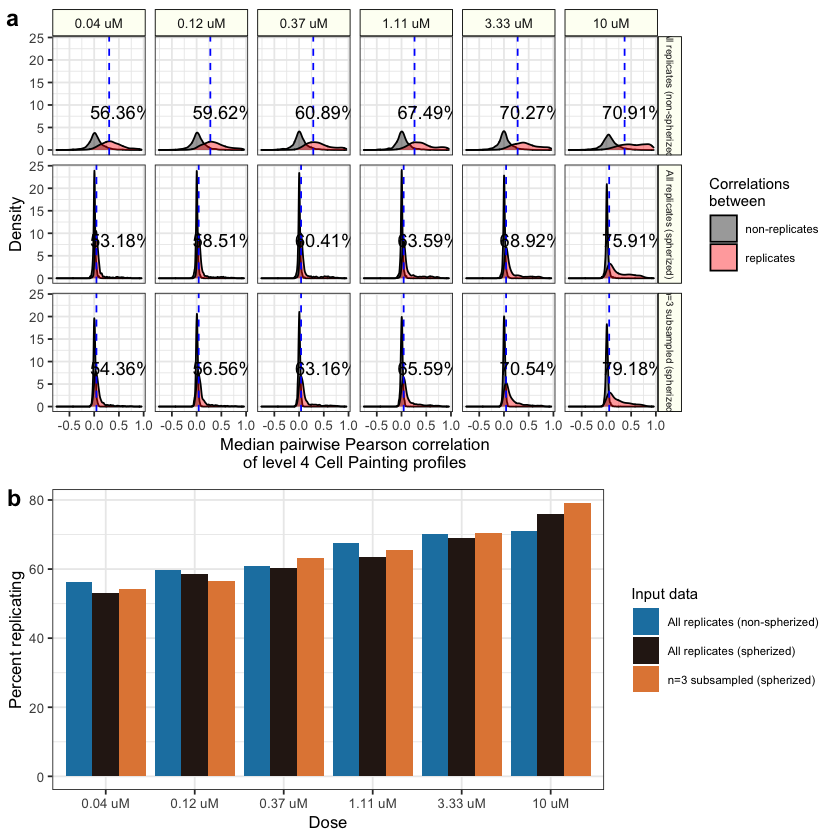

In [11]:
sup_fig3_gg <- cowplot::plot_grid(
    sup_fig3_top_gg,
    sup_fig3_bottom_gg,
    labels = c("a", "b"),
    rel_heights = c(1, 0.75),
    nrow = 2
)

sup_fig3_gg

In [12]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, sup_fig3_gg, base_width = 10, base_height = 8, dpi = 500)
}